In [1]:
from climada.engine.impact_calc import ImpactCalc
from climada.util.api_client import Client
from climada.entity import ImpactFuncSet, ImpfTropCyclone
from climada.trajectories.snapshot import Snapshot

client = Client()

exp_present = client.get_litpop(country="Haiti")

haz_present = client.get_hazard(
    "tropical_cyclone",
    properties={
        "country_name": "Haiti",
        "climate_scenario": "historical",
        "nb_synth_tracks": "10",
    },
)
exp_present.assign_centroids(haz_present, distance="approx")

impf_set = ImpactFuncSet([ImpfTropCyclone.from_emanuel_usa()])
exp_present.gdf.rename(columns={"impf_": "impf_TC"}, inplace=True)
exp_present.gdf["impf_TC"] = 1
exp_present.gdf["group_id"] = (exp_present.gdf["value"] > 500000) * 1
snap = Snapshot(exp_present, haz_present, impf_set, 2018)

ERROR 1: PROJ: proj_create_from_database: Open of /home/sjuhel/miniforge3/envs/cb_refactoring/share/proj failed
/home/sjuhel/miniforge3/envs/cb_refactoring/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


<Axes: title={'center': 'TC 1: Emanuel 2011'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>

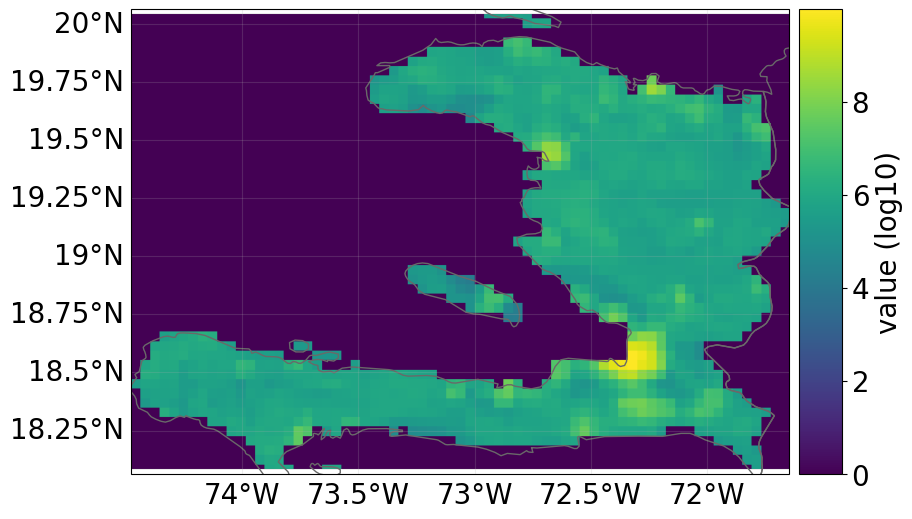

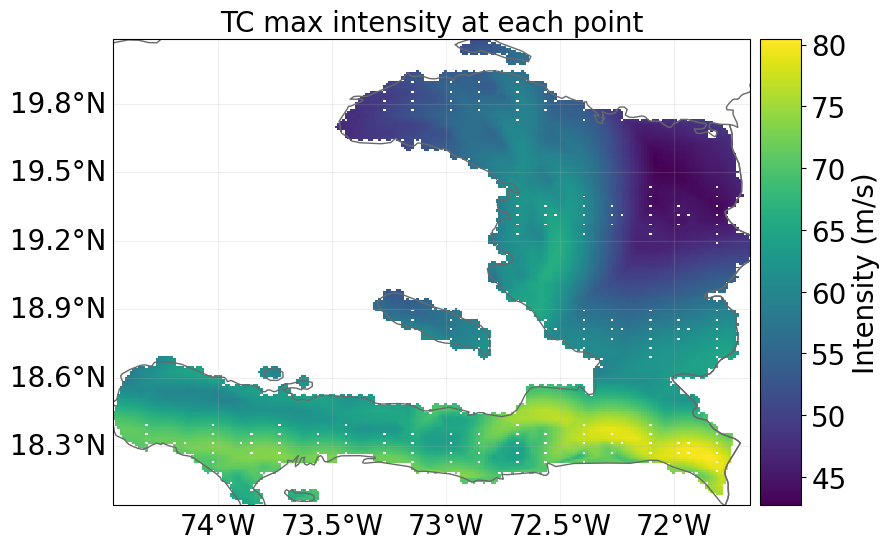

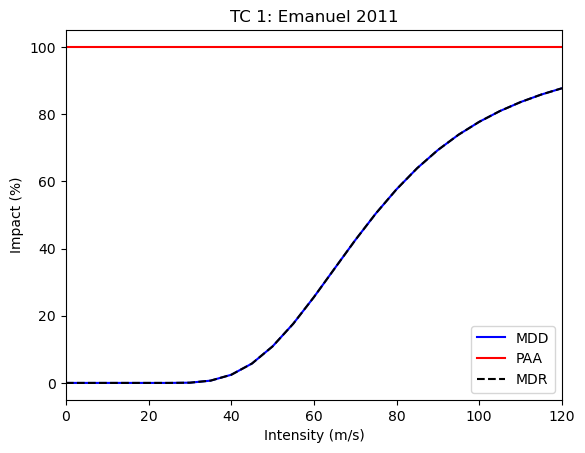

In [2]:
snap.exposure.plot_raster()
snap.hazard.plot_intensity(0)
snap.impfset.plot()

In [3]:
import copy

future_year = 2040
exp_future = copy.deepcopy(exp_present)
exp_future.ref_year = future_year
n_years = exp_future.ref_year - exp_present.ref_year + 1
growth_rate = 1.02
growth = growth_rate**n_years
exp_future.gdf["value"] = exp_future.gdf["value"] * growth

haz_future = client.get_hazard(
    "tropical_cyclone",
    properties={
        "country_name": "Haiti",
        "climate_scenario": "rcp60",
        "ref_year": str(future_year),
        "nb_synth_tracks": "10",
    },
)
exp_future.assign_centroids(haz_future, distance="approx")
impf_set = ImpactFuncSet(
    [
        ImpfTropCyclone.from_emanuel_usa(v_half=60.0),
    ]
)
exp_future.gdf.rename(columns={"impf_": "impf_TC"}, inplace=True)
exp_future.gdf["impf_TC"] = 1

<Axes: title={'center': 'TC 1: Emanuel 2011'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>

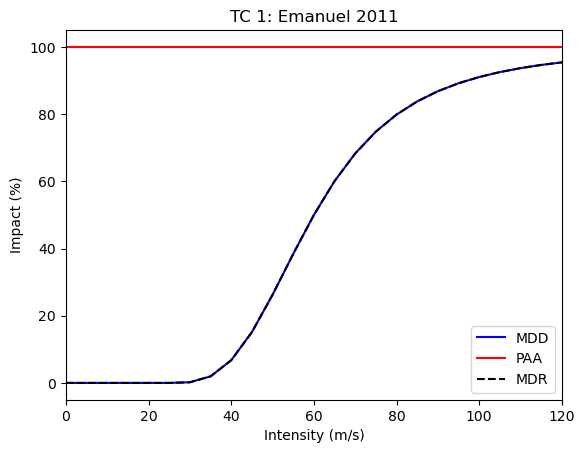

In [4]:
impf_set.plot()

In [5]:
snap2 = Snapshot(exp_future, haz_future, impf_set, 2040)

In [6]:
snapcol = [snap, snap2]

In [15]:
from climada.engine.option_appraisal.appraiser import MeasuresAppraiser

# Define the measure
from climada.entity.measures.base import (
    Measure,
    helper_hazard,
    helper_impfset,
    helper_exposure,
)
from climada.entity.measures import MeasureSet
from climada.entity.measures.cost_income import CostIncome


# Measure 1
meas_1 = Measure(
    haz_type="TC",
    name="Measure A",
    hazard_change=helper_hazard(
        intensity_multiplier=1, intensity_substract=5
    ),  # Decrease wind speeds by 5 m/s
    cost_income=CostIncome(
        mkt_price_year=2018,
        init_cost=-5_000_000_000,
        periodic_cost=1000,
        periodic_income=500,
        freq="AS-JAN",
    ),
)

# Measure 2
meas_2 = Measure(
    haz_type="TC",
    name="Measure B",
    impfset_change=helper_impfset(
        haz_type="TC", impf_paa_modifier={1: (1, -0.10)}
    ),  # 10% fewer assets affected
    cost_income=CostIncome(
        mkt_price_year=2018,
        init_cost=-220_000_000,
        periodic_cost=2000,
        periodic_income=50,
        freq="AS-JAN",
    ),
)

# gather all measures
meas_set = MeasureSet(measures=[meas_1, meas_2])

In [16]:
appraiser = MeasuresAppraiser(snapcol, measure_set=meas_set)

100%|████████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 714.57it/s]


array([<Axes: title={'center': 'Risk between 2018-01-01 and 2040-01-01 (Average impact)'}, ylabel='USD'>,
       <Axes: title={'center': 'Measure: Measure A'}>,
       <Axes: title={'center': 'Measure: Measure B'}>], dtype=object)

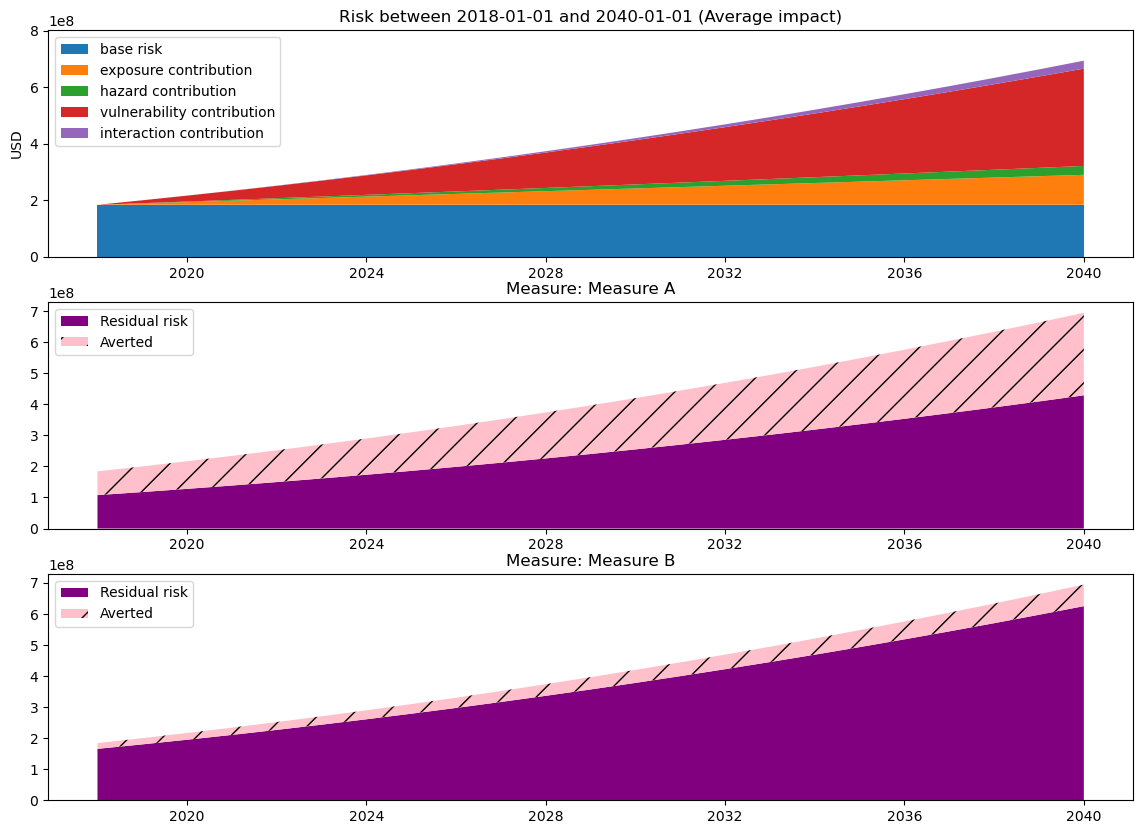

In [ ]:
appraiser.plot_per_date_waterfall_CB()

In [18]:
appraiser.per_date_CB()

100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 672.87it/s]


,date,group,measure,metric,risk,reference risk,averted risk,measure net cost,measure cost benefit,cumulated measure cost,cumulated measure benefit,cost/benefit ratio
0,2018-01-01,All,no_measure,aai,1.840432e+08,1.840432e+08,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,NaN
0,2019-01-01,All,no_measure,aai,2.000396e+08,2.000396e+08,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,NaN
0,2020-01-01,All,no_measure,aai,2.166844e+08,2.166844e+08,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,NaN
0,2021-01-01,All,no_measure,aai,2.339834e+08,2.339834e+08,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,NaN
0,2022-01-01,All,no_measure,aai,2.519424e+08,2.519424e+08,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
87,2039-01-01,1,Measure B,aai,5.965654e+08,6.628505e+08,6.628505e+07,1950.0,6.628310e+07,3.132032e+10,4.976914e+11,0.062931
88,2040-01-01,0,Measure A,aai,6.316604e+05,1.040877e+06,4.092167e+05,500.0,4.087167e+05,3.132032e+10,4.976918e+11,0.062931
89,2040-01-01,1,Measure A,aai,4.283364e+08,6.936344e+08,2.652981e+08,500.0,2.652976e+08,3.132032e+10,4.979571e+11,0.062898
90,2040-01-01,0,Measure B,aai,9.367894e+05,1.040877e+06,1.040877e+05,1950.0,1.021377e+05,3.132032e+10,4.979572e+11,0.062898


In [19]:
appraiser.per_period_CB()

100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 672.60it/s]


,period,measure,group,metric,reference risk,averted risk,risk,measure net cost,measure cost benefit
0,2018-01-01 to 2040-01-01,Measure A,0,aai,1.414905e+07,5.702884e+06,8.446168e+06,5.000010e+09,-4.994308e+09
1,2018-01-01 to 2040-01-01,Measure A,1,aai,9.465607e+09,3.716407e+09,5.749200e+09,5.000010e+09,-1.283603e+09
2,2018-01-01 to 2040-01-01,Measure A,All,aai,9.479757e+09,3.722110e+09,5.757647e+09,5.000010e+09,-1.277901e+09
3,2018-01-01 to 2040-01-01,Measure A,All,rp_100,3.117856e+11,1.279316e+11,1.838540e+11,5.000010e+09,1.229316e+11
4,2018-01-01 to 2040-01-01,Measure A,All,rp_50,1.782113e+11,9.305202e+10,8.515925e+10,5.000010e+09,8.805201e+10
5,2018-01-01 to 2040-01-01,Measure A,All,rp_500,8.083646e+11,1.378666e+11,6.704980e+11,5.000010e+09,1.328666e+11
6,2018-01-01 to 2040-01-01,Measure B,0,aai,1.414905e+07,1.414905e+06,1.273415e+07,2.200428e+08,-2.186279e+08
7,2018-01-01 to 2040-01-01,Measure B,1,aai,9.465607e+09,9.465607e+08,8.519047e+09,2.200428e+08,7.265179e+08
8,2018-01-01 to 2040-01-01,Measure B,All,aai,9.479757e+09,9.479757e+08,8.531781e+09,2.200428e+08,7.279328e+08
9,2018-01-01 to 2040-01-01,Measure B,All,rp_100,3.117856e+11,3.117856e+10,2.806071e+11,2.200428e+08,3.095852e+10


In [20]:
appraiser.eai_metrics()

100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 247.52it/s]


,date,group,measure,metric,coord_id,risk,reference risk,averted risk,measure net cost,measure cost benefit
0,2018-01-01,0,no_measure,eai,2,983.793263,983.793263,0.000000,0.0,0.000000
3,2018-01-01,0,no_measure,eai,3,880.220041,880.220041,0.000000,0.0,0.000000
6,2018-01-01,0,no_measure,eai,4,613.657134,613.657134,0.000000,0.0,0.000000
9,2018-01-01,0,no_measure,eai,5,788.751994,788.751994,0.000000,0.0,0.000000
12,2018-01-01,0,no_measure,eai,6,807.108756,807.108756,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
61129,2040-01-01,1,Measure B,eai,1319,12637.851986,14042.057762,1404.205776,1950.0,-545.794224
61130,2040-01-01,1,Measure B,eai,1323,3520.771561,3911.968401,391.196840,1950.0,-1558.803160
61131,2040-01-01,1,Measure B,eai,1324,3711.293164,4123.659071,412.365907,1950.0,-1537.634093
61132,2040-01-01,1,Measure B,eai,1327,5191.892403,5768.769336,576.876934,1950.0,-1373.123066


In [21]:
from climada.engine.option_appraisal.appraiser import PlannedMeasuresAppraiser

In [22]:
planner = {"Measure A": (2030, 2050), "Measure B": (2018, 2030)}

planned = PlannedMeasuresAppraiser(snapcol, measure_set=meas_set, planner=planner)

100%|████████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 676.31it/s]


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

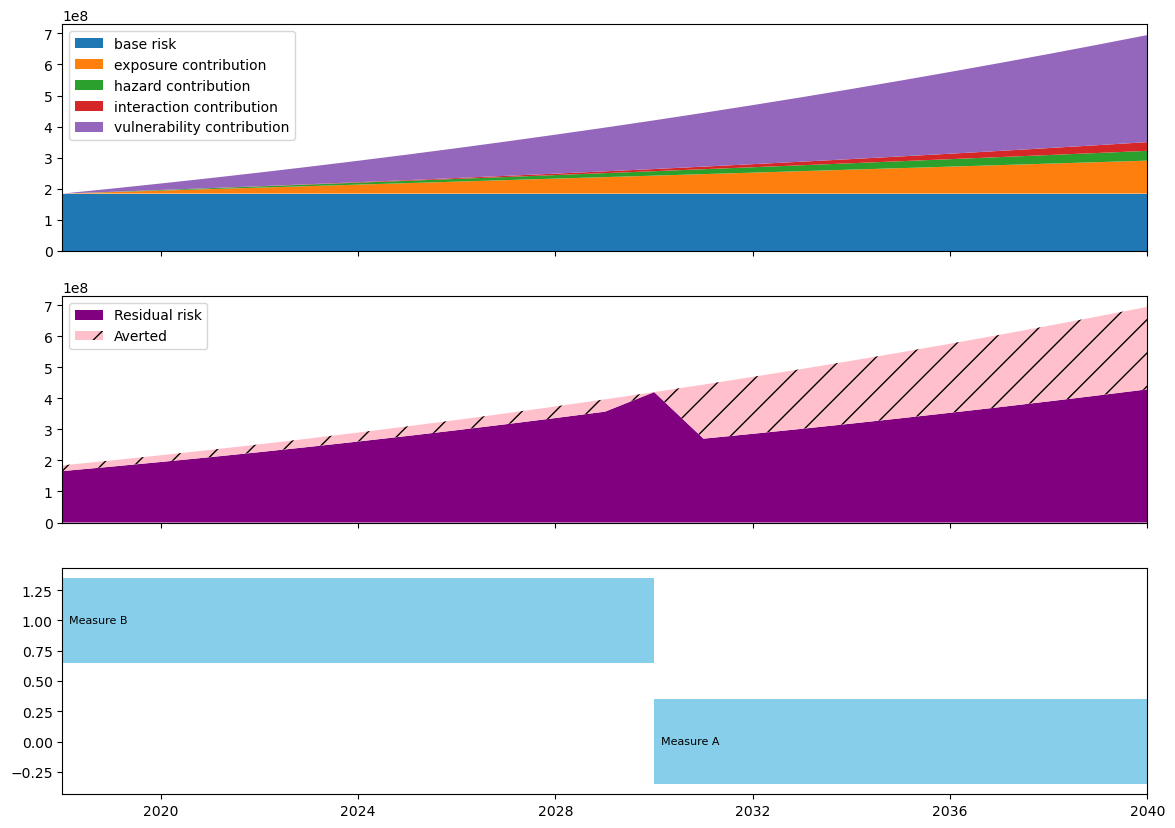

In [23]:
planned.plot_per_date_waterfall_CB()

In [24]:
planned.aai_metrics()

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 608.74it/s]


,measure,date,group,metric,risk,reference risk,averted risk,measure net cost,measure cost benefit
10,Measure B,2018-01-01,All,aai,1.656389e+08,1.840432e+08,1.840432e+07,219999950.0,-2.015956e+08
11,Measure B,2019-01-01,All,aai,1.800357e+08,2.000396e+08,2.000396e+07,1950.0,2.000201e+07
12,Measure B,2020-01-01,All,aai,1.950160e+08,2.166844e+08,2.166844e+07,1950.0,2.166649e+07
13,Measure B,2021-01-01,All,aai,2.105851e+08,2.339834e+08,2.339834e+07,1950.0,2.339639e+07
14,Measure B,2022-01-01,All,aai,2.267482e+08,2.519424e+08,2.519424e+07,1950.0,2.519229e+07
15,Measure B,2023-01-01,All,aai,2.435105e+08,2.705672e+08,2.705672e+07,1950.0,2.705477e+07
16,Measure B,2024-01-01,All,aai,2.608773e+08,2.898637e+08,2.898637e+07,1950.0,2.898442e+07
17,Measure B,2025-01-01,All,aai,2.788537e+08,3.098375e+08,3.098375e+07,1950.0,3.098180e+07
18,Measure B,2026-01-01,All,aai,2.974451e+08,3.304945e+08,3.304945e+07,1950.0,3.304750e+07
19,Measure B,2027-01-01,All,aai,3.166565e+08,3.518406e+08,3.518406e+07,1950.0,3.518211e+07


In [25]:
planned.aai_per_group_metrics()

100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 675.60it/s]


,measure,date,group,metric,risk,reference risk,averted risk,measure net cost,measure cost benefit
21,Measure B,2018-01-01,1,aai,1.653939e+08,1.837711e+08,1.837711e+07,219999950.0,-2.016228e+08
20,Measure B,2018-01-01,0,aai,2.449693e+05,2.721881e+05,2.721881e+04,219999950.0,-2.199727e+08
22,Measure B,2019-01-01,0,aai,2.665521e+05,2.961690e+05,2.961690e+04,1950.0,2.766690e+04
23,Measure B,2019-01-01,1,aai,1.797691e+08,1.997434e+08,1.997434e+07,1950.0,1.997239e+07
25,Measure B,2020-01-01,1,aai,1.947269e+08,2.163633e+08,2.163633e+07,1950.0,2.163438e+07
24,Measure B,2020-01-01,0,aai,2.890195e+05,3.211328e+05,3.211328e+04,1950.0,3.016328e+04
26,Measure B,2021-01-01,0,aai,3.123797e+05,3.470886e+05,3.470886e+04,1950.0,3.275886e+04
27,Measure B,2021-01-01,1,aai,2.102727e+08,2.336363e+08,2.336363e+07,1950.0,2.336168e+07
28,Measure B,2022-01-01,0,aai,3.366410e+05,3.740456e+05,3.740456e+04,1950.0,3.545456e+04
29,Measure B,2022-01-01,1,aai,2.264115e+08,2.515684e+08,2.515684e+07,1950.0,2.515489e+07
